In [1]:
from migdalcalc import migdalcalc
from migdalcalc.migdal import kinematics as kin
from migdalcalc.migdal import ionization as ion
import numpy as np
import scipy.integrate as integrate
import scipy.interpolate as interp


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = False

In [2]:
#Change these Variables here
En = 180e3 #Incident nuetron energy in eV
Angle = 15 #Lab Frame Scattering angle in deg

In [3]:
#Define various useful constants and quantities

A = 40
N_per_g = (6.02e23/A)
barns_to_cm2 = 1e-24
flux = 100 #nuetrons/cm^2/second
days_to_seconds = 60*60*24 #days to seconds
phi_int = 2*np.pi #integral over 2pi in the azimuthal angle

R = 5 #cm
L = 1 #cm

V = (np.pi*R**2)*L
density = 1.395 #g / cm^3

mass = 1000 #grams

rate_prefactor = N_per_g*mass*barns_to_cm2*flux*days_to_seconds
print(f'{4.7*rate_prefactor:.2e}')

6.11e+08


In [4]:
#Cross Section of Elastic Scattering
Ar_migdal = migdalcalc.migdalcalc(target="Ar-40")

#Compute the Migdal Cross section
c_range = np.linspace(-1, 1, 360)
angles = np.linspace(0, 180, 360)    

mig_dE_spectrum = Ar_migdal.d2R_dc_dDeltaE(En)

mig_angle_arr = []
mig_c_arr = []

for angle in angles:
    c = np.cos(np.pi*angle/180)
    dE_max = kin.DeltaE_Max(A, En, c)
    mig_angle = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, dE_max, limit=200, epsrel=1e-3)[0]
    
    mig_angle_arr.append(mig_angle)
    
for c in c_range:
    dE_max = kin.DeltaE_Max(A, En, c)
    mig_c = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, dE_max, limit=200, epsrel=1e-3)[0]
    
    mig_c_arr.append(mig_c)
    
    
    
elastic_xsec = Ar_migdal.nuc.SIG(En)
mig_total_xsec = phi_int*integrate.trapz(mig_c_arr, c_range)
mig_rate = np.floor(mig_total_xsec*rate_prefactor)

print(f"Argon Elastic Cross Section (barns): {Ar_migdal.nuc.SIG(En):.3f}")
print(f"Argon Migdal Cross Section (barns): {mig_total_xsec:.3e}")

print()

print(f"Ratio migdal/elastic: {mig_total_xsec/elastic_xsec:.3e}")

print(f"Migdal Rate: {mig_rate:.3e} evts/kg/day")

Argon Elastic Cross Section (barns): 4.718
Argon Migdal Cross Section (barns): 1.756e-01

Ratio migdal/elastic: 3.721e-02
Migdal Rate: 2.283e+07 evts/kg/day


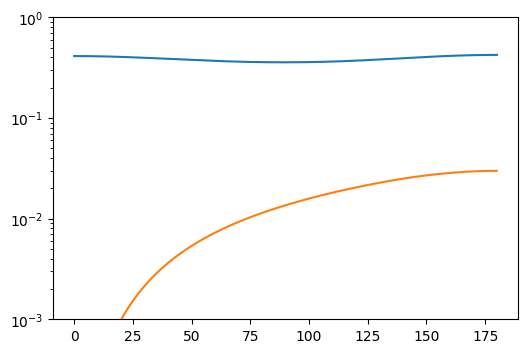

In [11]:
Ar40_elastic = Ar_migdal.nuc.dSig_dOmega(En)

plt.plot(angles, Ar40_elastic(np.cos(angles*np.pi/180)))
plt.plot(angles, mig_angle_arr)

plt.yscale('log')
plt.ylim(1e-3,1)

plt.show()

First Make a Simple estimate assuming 19.5 eV/electron and a fano factor of 0.05

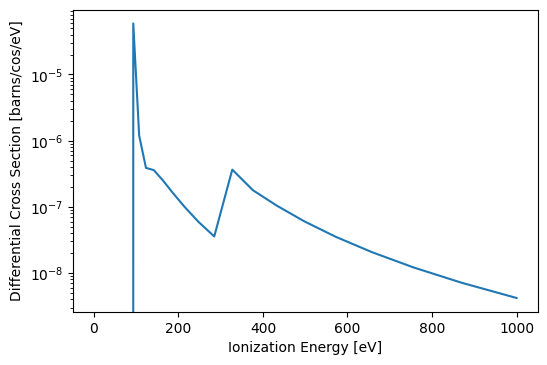

Elastic Recoil Energy: 306.41 eV


In [13]:
Ar_quench = lambda E: 0.25

c = np.cos(np.pi*Angle/180)

migdal_ionization_spectrum = Ar_migdal.dR_dEion(c, En, Ar_quench)

Eion_arr = np.geomspace(1e-3, 1000, 100)


plt.plot(Eion_arr, migdal_ionization_spectrum(Eion_arr))
plt.yscale('log')
plt.ylabel('Differential Cross Section [barns/cos/eV]')
plt.xlabel('Ionization Energy [eV]')
plt.show()

#binned cross section in barns/deg (azimuth)/cos theta
binned_migdal_spectrum = ion.noblegas_electron_spectrum_binned(migdal_ionization_spectrum, Ar_quench, 19.5, 0.05,
                                                              En, c, 40, flux=1, number_of_bins=20, fano=True)

elastic_angular_spectrum = Ar_migdal.nuc.dSig_dOmega(En)
elastic_xsec = elastic_angular_spectrum(c)
migdal_xsec = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, 50000,limit=100, epsrel=1e-3)[0]
binned_elastic_spectrum = ion.noblegas_electron_spectrum_binned_elastic(elastic_xsec, Ar_quench, 19.5, 0.05,
                                                              En, c, 40, flux=1, number_of_bins=20, fano=True )


print(f"Elastic Recoil Energy: {kin.E_Recoil(0, c, A, En):.2f} eV")

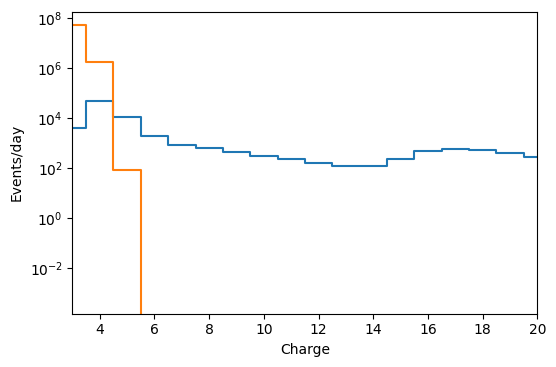

In [14]:
#when changing energies and angles, might have to play around a bit with the axes to get a reasonable looking plot

plt.step(binned_migdal_spectrum[0], np.multiply(rate_prefactor,binned_migdal_spectrum[1]),where='mid')
plt.step(binned_elastic_spectrum[0], np.multiply(rate_prefactor, binned_elastic_spectrum[1]), where='mid')
plt.yscale('log')
plt.xlim(3, 20)
plt.xlabel("Charge")
plt.ylabel('Events/day')
plt.show()

Here we do a simple MC approach to allow us to put in more complicated charge production models

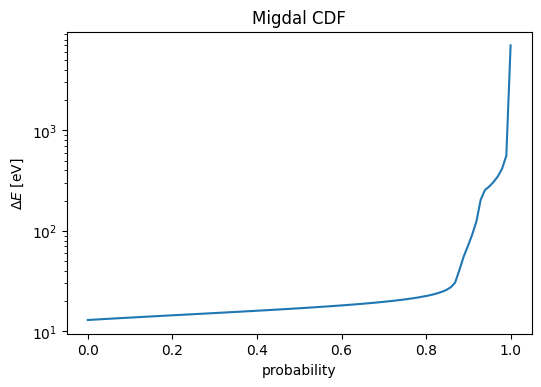

0.0013886155490859808


In [8]:
N_evts = 10000000

#compute the CDF for deltaE from migdal
#dE_max = kin.DeltaE_Max(A, En, c)
dE_min = 13 #13 eV to even ionize a valence electron
dE_max = 8000 #arbitrary cutoff
dE_range = np.geomspace(dE_min, dE_max, 2000)

c = np.cos(np.pi*Angle/180)

probs = []

norm = integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 13, dE_max, limit=100, epsrel=1e-3)[0]

for dE in dE_range:
    p = (1/norm)*(integrate.quad(lambda dE: mig_dE_spectrum(dE, c), 0, dE,limit=100, epsrel=1e-3)[0])
    probs.append(p)

migdal_CDF = interp.interp1d(probs, dE_range, bounds_error=False, fill_value=0, kind='linear')
p_space = np.linspace(0, 1, 100)
plt.plot(p_space, migdal_CDF(p_space))
plt.yscale('log')
plt.ylabel(r'$\Delta E$ [eV]')
plt.xlabel('probability')
plt.title('Migdal CDF')
plt.show()



n_electron_arr = []

migdal_p = 1 - (elastic_xsec/(migdal_xsec + elastic_xsec))

print(migdal_p)

mig_count = 0
elastic_count = 0


#TODO replace basic quenching with models sent by Alan
highest_dE = 0
for n in range(N_evts):
    r = np.random.rand(1)[0]
    
    if(r < migdal_p):
        mig_count += 1
        s = np.random.rand(1)[0]
        dE = migdal_CDF(s)
        highest_dE = np.maximum(dE,highest_dE)
        recoil_energy = kin.E_Recoil(dE, c, A, En)
        E_ion = recoil_energy*Ar_quench(recoil_energy) + dE
        n_elec = np.floor(E_ion/19.5)
        n_electron_arr.append(n_elec)
        continue
        
    elastic_count += 1
    continue #for now skip elestic events
    elastic_recoil_E = kin.E_Recoil(0, c, A, En)
    n_elec = np.floor(elastic_recoil_E*Ar_quench(elastic_recoil_E)/19.5) 

    n_electron_arr.append(n_elec)
    
#Histogram of results
#we take the normalized histo, multiply by the total cross section, then convert to events/kg/day
scale_factor = (elastic_xsec + migdal_xsec)*rate_prefactor
scale_factor = 1

highest_bin = 30
bin_edges = np.arange(1, highest_bin + 1, dtype=int)

n_elec_hist, bin_edges = np.histogram(n_electron_arr, bins=bin_edges, density = True)

n_elec_hist = np.multiply(n_elec_hist, scale_factor)

bins = bin_edges[:-1]



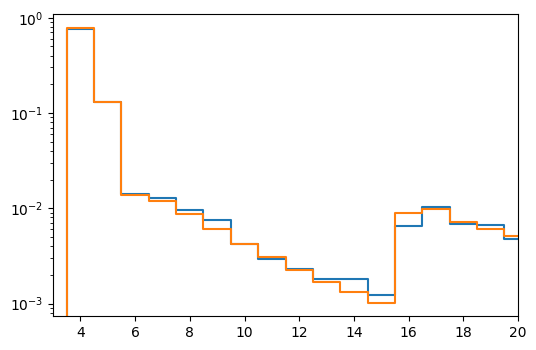

In [9]:
plt.step(bins, n_elec_hist,where='mid')

scale_factor = np.sum(n_elec_hist)/(np.sum(binned_migdal_spectrum[1]))
plt.step(binned_migdal_spectrum[0], np.multiply(scale_factor,binned_migdal_spectrum[1]),where='mid')

plt.yscale('log')
plt.xlim(3, 20)
plt.show()